In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import statistics
import scipy.integrate as integrate
import math

In [2]:
def hash_func(s,n,A):
    out = 0
    for i in range(len(s)):
        if s[i].isdigit():
            out += A[i]*int(s[i])
        else:
            out += A[i]*(ord(s[i])-87)
    
    out = out%n
    out = '{0:031b}'.format(out)
    out = out[-31:]
    return out

First of all we check if the hashing function maps elements to binary numbers in uniformly distributed

In [14]:
file = open("hash.txt", "r")

In [15]:
n = (2**31)-1
len_string = 33
A = random.sample(range(0, n-1), len_string + 1)

y = []
for line in file:
    val = hash_func(line, n, A)
    y.append(int(val, 2))

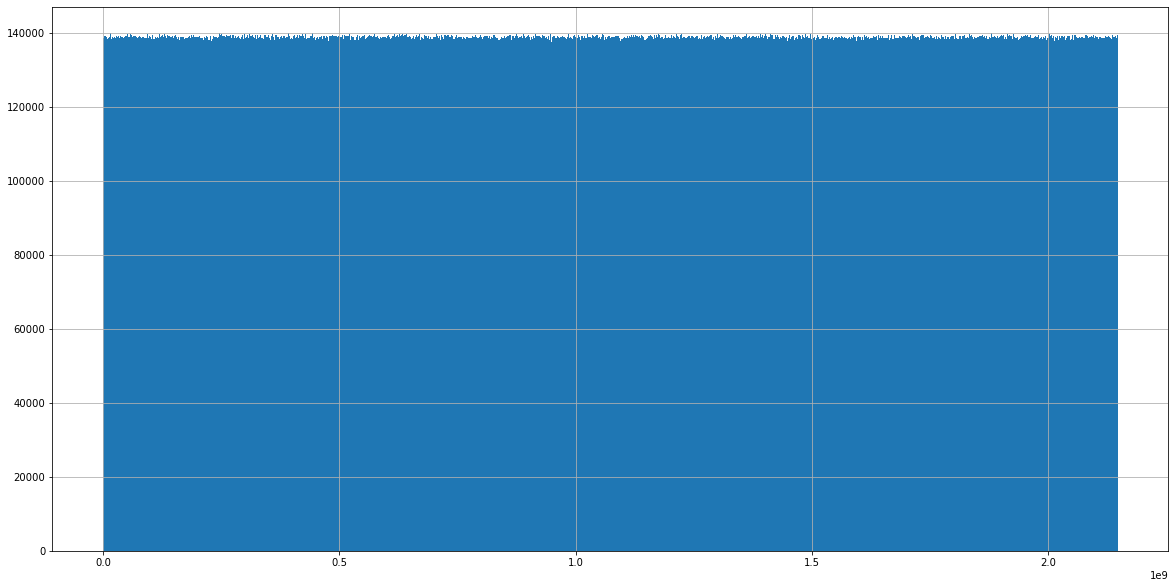

In [18]:
plt.figure(figsize=(20, 10))
plt.hist(y, bins = 1000)
plt.grid()
plt.show()

### The Flajolet–Martin algorithm

We have a multiset of elements and we wanted to compute the cardinality of the multiset.
Assume our multiset as $S$, with elements $e_1, e_2, ...,  e_n$. 

Lets say we are given a function $hash\_func(e_j)$ which maps elements to binary numbers in uniformly distributed over range $0$ to $2^L-1$.

We also hold a hash called *BITMAP* of size $L$ and initiate all the values to $0$. Now we loop through all the hashed values and we find the least significant $1$-bit as $x$, then we mark that *BITMAP*$[x]$ as $1$.

If we find the smallest index $i$ in *BITMAP* such that *BITMAP*$[i] = 0$ , then , we can estimate that cardinality of the multiset as $2^i$ .

In [3]:
file = open("hash.txt", "r")

In [4]:
len_strings = 33
n = (2**31)-1
A = random.sample(range(0, n-1), len_strings + 1)

In [5]:
def f_p(y): #returns the least significant 1-bit of y
    if int(y, 2) == 0:
        return 26
    
    k = int(len(y)-1)
    while 1:
        if int(y[k]) != 0:
            return int(len(y)-1) - k
        k -= 1   #the min k such that bit(y,k) ≠ 0

In [9]:
bitmax = np.zeros(32)

for line in file:
    el = hash_func(line, n, A)
    x = f_p(el)
    bitmax[x] = 1
    
print("BITMAP : " + str(bitmax))

idx = 0
while bitmax[idx]!=0:
    idx+=1

print("Index : " + str(idx))

#estimated cardinality
est_card = pow(2,idx)

print("Estimated cardinality : " + str(est_card))


BITMAP : [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 0. 0. 0. 0. 0.]
Index : 27
Estimated cardinality : 134217728


In [10]:
err = ((est_card/125000000)-1)*100
print(str(round(err, 3))+"%")

7.374%


### HyperLogLog Algorithm

The input is a set of data items $S$, that is, a stream whose elements are read
sequentially. The output is an estimate of the cardinality, defined as the number of distinct elements
in $S$. 

Given a binary string $s \in S$, let $\rho(s)$ represent the position of the leftmost $1$ (equivalently one plus the length of the initial run of $0$’s). 

Each element of $S$ is split into subsets $S_1, S_2, ... , S_m$ based on the first $M$ bits of hashed values, where $m = 2^M$. For each subset $S_j$ we define:

$S^{(j)} = Max(S_j):=\max\limits_{x \in S_j}\rho (x)$

The estimated cardinality is:

$E:=\alpha_{m}m^{2}Z$

Where:

* $\alpha_m := \bigg(m{\displaystyle\int}_{0}^{\infty}\bigg( log_2\big( {{2+u}\over{1+u}} \big) \bigg)^{m}du\bigg)^{-1}$

* $m = 2^M$

* $Z = \bigg( \displaystyle\sum\limits_{j=1}^{m}2^{-S^{(j)}} \bigg)^{-1}$

In [3]:
# Given a binary number as a string it counts the number of zeros before the first 1
def countZeros(num):
    count = 0
    for bit in num:
        count+=1
        if int(bit) != 0:
            return count
    return len(num)

In [4]:
# This is the function that needs to be integrated to calculate alpha_m
def func(u, m):
    return (math.log2((2+u)/(1+u)))**m

In [5]:
def alpha_m(m):
    
    integral = integrate.quad(func, 0, np.infty, args = (m))[0]
    
    return (integral*m)**(-1)

In [6]:
def getBuckets(M, buckets, value, n, A):
    
    binary_num = hash_func(value, n, A)

    m = 2**M
    
    num_zeros = countZeros(binary_num[M:])
    if buckets[int(binary_num[:M], 2)] < num_zeros:
        buckets[int(binary_num[:M], 2)] = num_zeros
    
    return buckets

In [7]:
def hyperLogLog(buckets, M):
    
    m = 2**M
    Z = 0
    for bucket in buckets:
        Z += 2**(-bucket)
    Z = Z**(-1)

    card = (m**2)*Z*alpha_m(m)
    
    return card

In [8]:
file = open("hash.txt", "r")

In [9]:
len_strings = 33
n = (2**31)-1 #primary number
A = random.sample(range(0, n-1), len_strings + 1)

In [10]:
M = 13
buckets = np.zeros(2**M)

for line in file:
    buckets = getBuckets(M, buckets, line, n, A)

print("Buckets : " + str(buckets))

Buckets : [17. 13. 15. ... 16. 14. 18.]


In [33]:
HLL = hyperLogLog(buckets, M)
print("Estimated cardinality : " + str(HLL))

Estimated cardinality : 125960784.13902305


In [34]:
err = ((HLL/125000000)-1)*100
print("error : " + str(round(err, 3))+"%")

error : 0.769%


For $m$ buckets, the avarage error is $\displaystyle{1.3}\over{\sqrt{m}}$

In [29]:
m = 2**M
err2 = (1.3/(m**(1/2)))*100
print("avarage error : "+str(round(err2, 3)) + "%")

avarage error : 1.436%


After another test of the HyperLogLog on the same set, we got the following results:

* Estimated cardinality : $127147271.53884749$

* error : $1.718\%$

If we average the errors, as we can see, the final result is closer to $1.436\%$:

${{1.718\% + 0.769\%} \over {2}} = 1.2435\%$